In [1]:
# imports
import openai
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
from sklearn.metrics import silhouette_score

openai.api_key = os.getenv("OPENAI_API_KEY")
COMPLETIONS_MODEL = "text-davinci-003"

# This path leads to a file with data and precomputed embeddings
embedding_path = "data/funding_eu.csv"

In [2]:
df = pd.read_csv(embedding_path)

In [3]:
embedding_df = pd.read_csv(embedding_path)

embedding_df["embedding"] = embedding_df.embedding.apply(eval).apply(np.array)

matrix = np.vstack(embedding_df.embedding.values)
matrix.shape

(630, 1536)

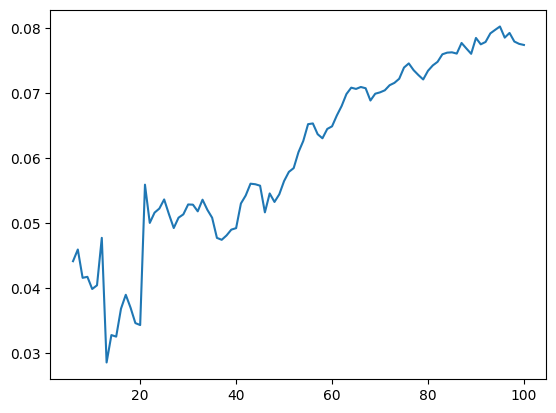

In [4]:
max_n_clusters = 100

# Run KMeans for different number of clusters
cluster_results_km = pd.DataFrame({'K': range(6, max_n_clusters+1), 'SIL': np.nan})
cluster_results_km.set_index('K', inplace=True)
for k in range(6, max_n_clusters+1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(matrix)
    cluster_results_km.loc[k, 'SIL'] = silhouette_score(matrix, kmeans.labels_)

cluster_results_km.idxmax(), cluster_results_km.max()
# plot silhouette score
plt.plot(cluster_results_km.index, cluster_results_km.SIL)

In [7]:
# best number of clusters
n_clusters = cluster_results_km.SIL.idxmax()
n_clusters

95

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/9_/zncbh_cn5gjcfgjxhvfnznw40000gn/T/ipykernel_46085/104575765.py:22: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(avg_x, avg_y, marker="x", color=color, s=100, edgecolors="black")
/var/folders/9_/zncbh_cn5gjcfgjxhvfnznw40000gn/T/ipykernel_46085/104575765.py:19: RuntimeWarning: Mean of empty slice.
  avg_x = xs.mean()
/Users/jonasscholz/Library/Python/3.11/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/9_/zncbh_cn5gjcfgjxhvfnznw40000gn/T/ipykernel_46085/104575765.py:20: Runtime

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

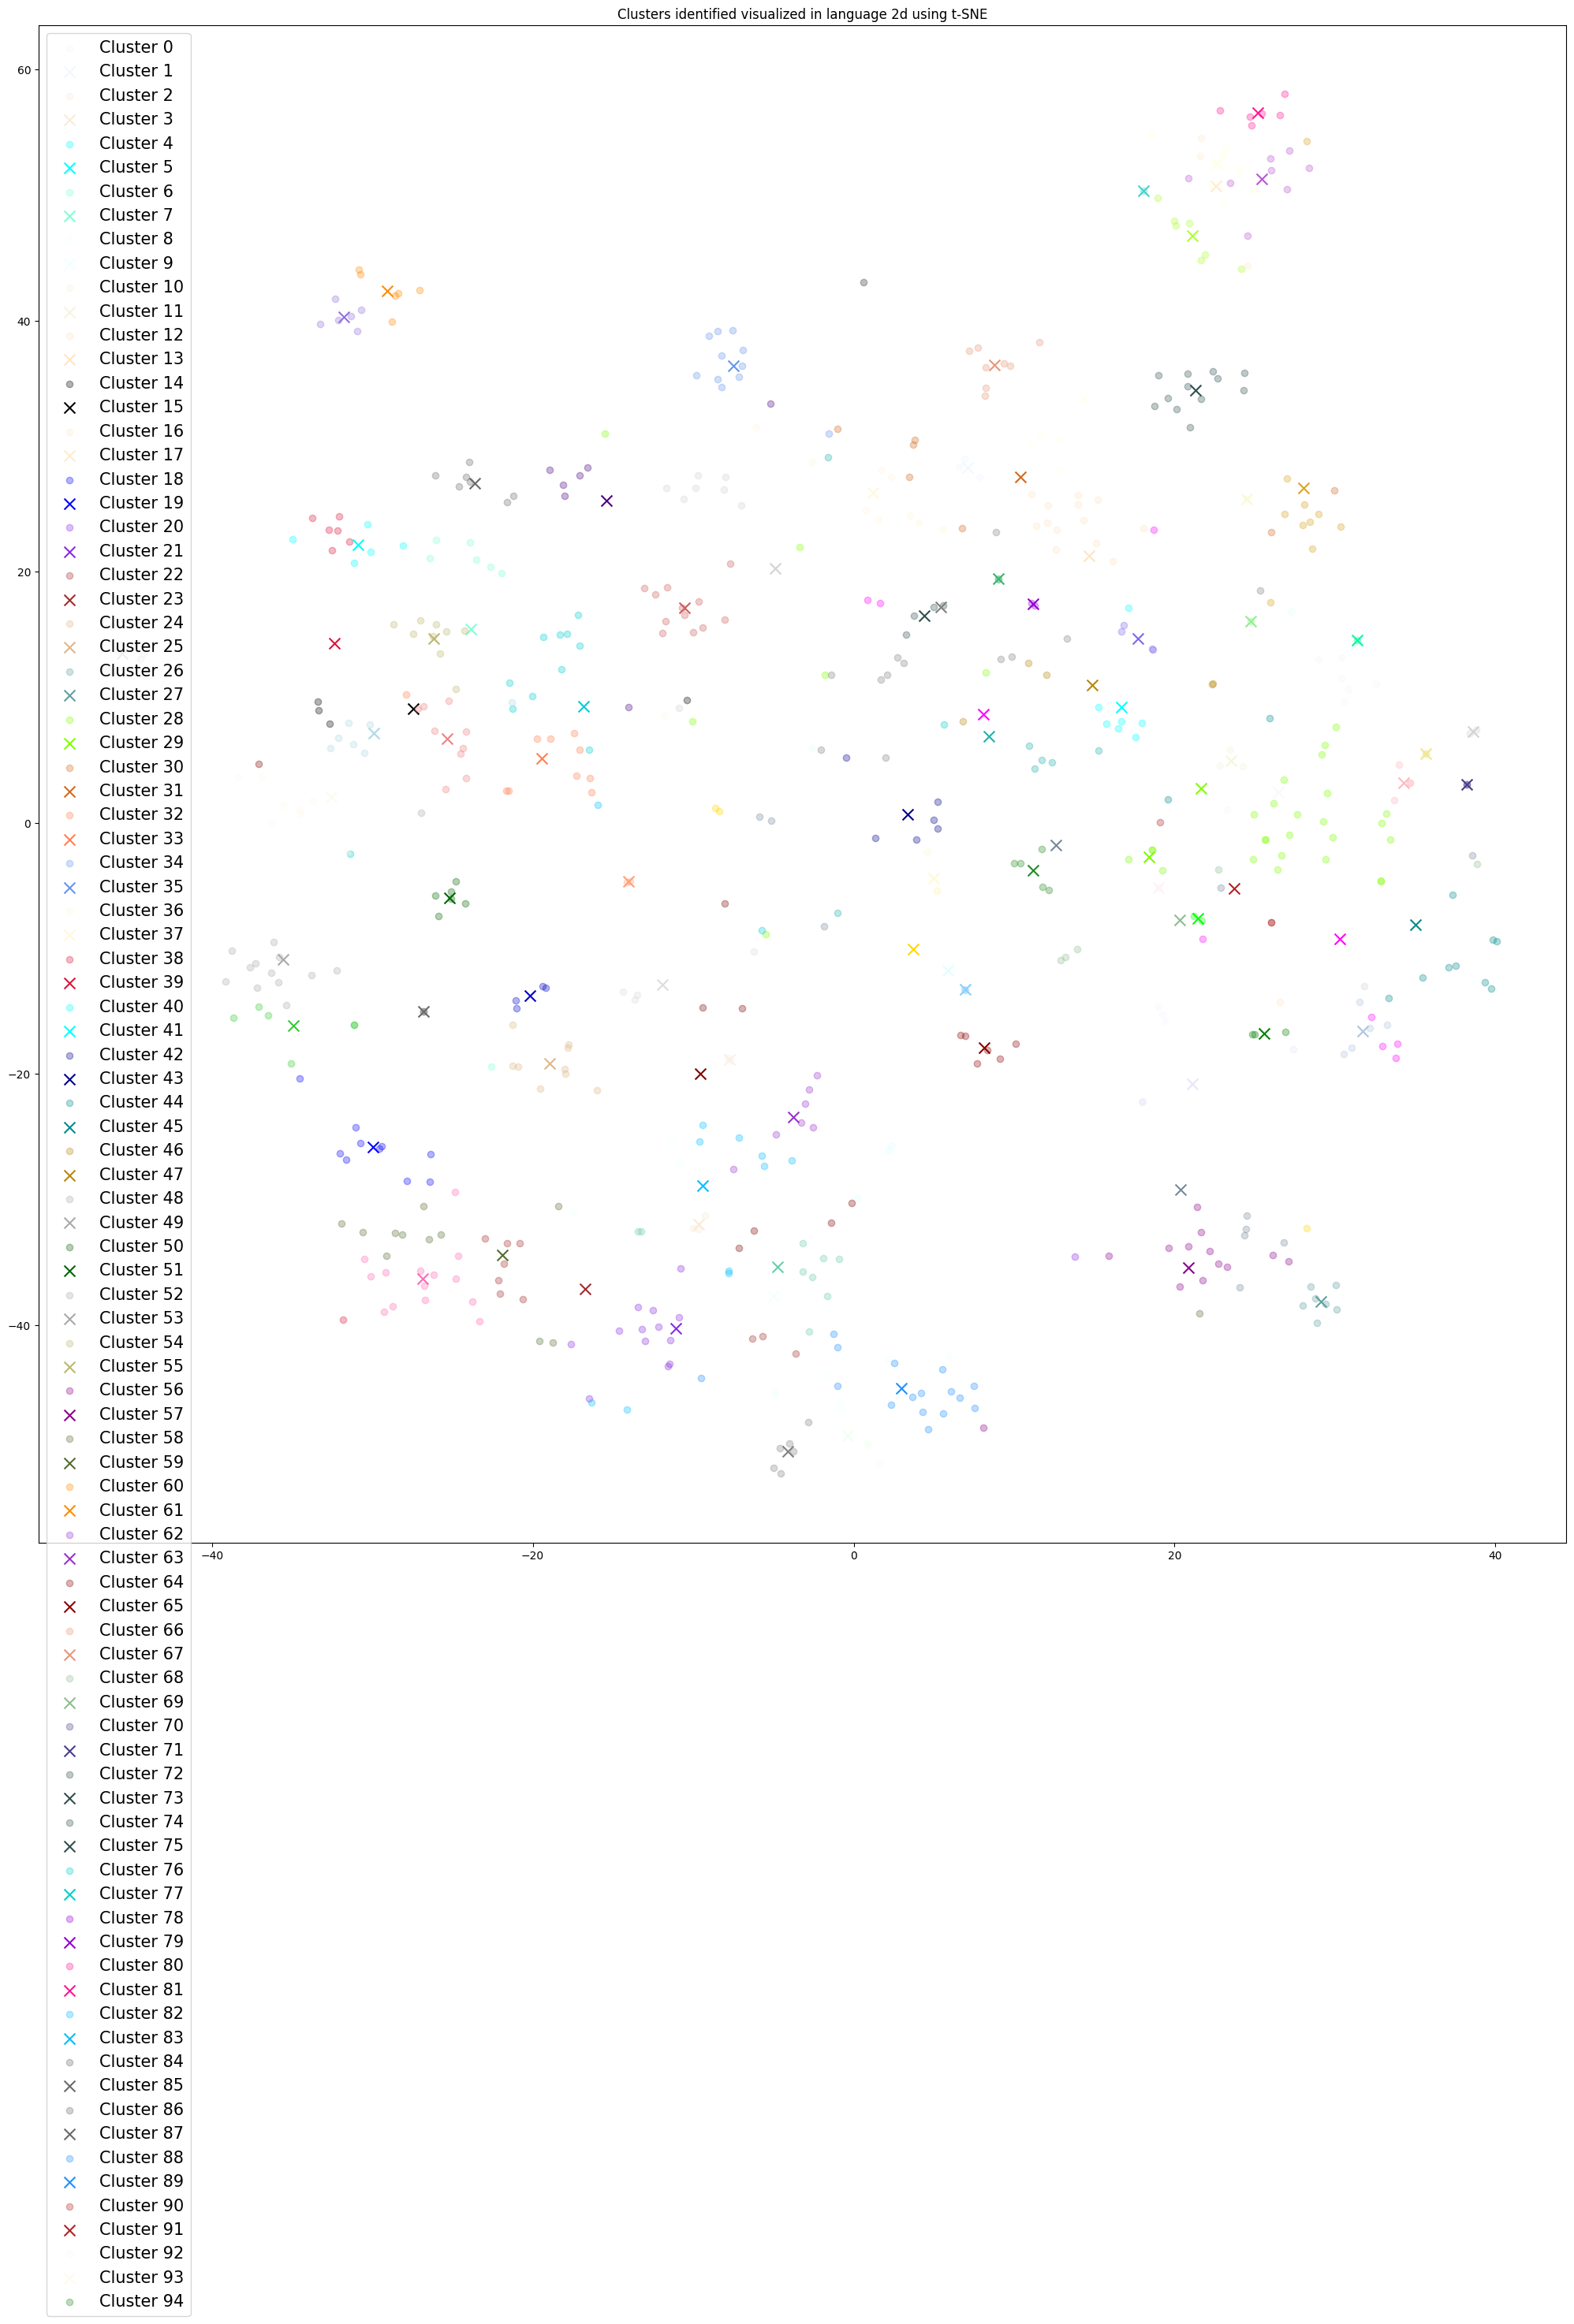

In [9]:

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
embedding_df["Cluster"] = labels

tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(mcolors.CSS4_COLORS):
    xs = np.array(x)[embedding_df.Cluster == category]
    ys = np.array(y)[embedding_df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100, edgecolors="black")
    # size of plot
    plt.rcParams["figure.figsize"] = (250, 250)
    

    """
    # add label to the center of each cluster
    plt.text(
        x=avg_x,
        y=avg_y,
        s="Cluster {}".format(category),
        fontsize=25,
        horizontalalignment="center",
        verticalalignment="center",
        bbox=dict(facecolor="white", alpha=0.5),
    )

    """
    # legend
    plt.legend(
        ["Cluster {}".format(i) for i in range(n_clusters)],
        loc="upper left",
        prop={"size": 15},
    )

plt.title("Clusters identified visualized in language 2d using t-SNE")

In [10]:
# We'll read 5 transactions per cluster as we're expecting some variation
transactions_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    funding_programs = "\n".join(
        embedding_df[embedding_df.Cluster == i]
        .title
        .sample(transactions_per_cluster, replace=True, random_state=42)
        .values
    )
    response = openai.Completion.create(
        model=COMPLETIONS_MODEL,
        # We'll include a prompt to instruct the model what sort of description we're looking for
        prompt=f'''Was haben die folgenden Förderprogramme gemeinsam?\n\Programme:\n"""\n{funding_programs}\n"""\n\nTheme:''',
        temperature=0,
        max_tokens=100,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )

    if response["choices"][0]["text"] == "":
        print("No theme identified")
    else:
        print(response["choices"][0]["text"].replace("\n", ""))

    #sample_cluster_rows = embedding_df[embedding_df.Cluster == i].sample(transactions_per_cluster, random_state=42)
    #for j in range(transactions_per_cluster):
    #    print(sample_cluster_rows.title.values[j], end="\n")
        

    print("-" * 100)

Cluster 0 Theme:  Alle Programme haben das Thema "Erhöhte Cybersicherheit".
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  Alle diese Förderprogramme unterstützen die Umsetzung der Anpassung an den Klimawandel-Mission.
----------------------------------------------------------------------------------------------------
Cluster 2 Theme:  Alle diese Förderprogramme haben das Ziel, ein operativer, offener und FAIRER EOSC-Ökosystem zu ermöglichen.
----------------------------------------------------------------------------------------------------
Cluster 3 Theme:  Alle Programme haben das Ziel, eine nachhaltige, sichere und wettbewerbsfähige Energieversorgung sowie saubere und wettbewerbsfähige Lösungen für alle Transportmodi zu fördern.
----------------------------------------------------------------------------------------------------
Cluster 4 Theme:  Alle Programme haben ein gemeinsames Thema, nämlich die Förderung 